In [103]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR, VARMAX

# Processing only Lake Level Data

In [232]:
# Read in the lake level data
level = pd.read_csv('partially_cleaned_salt_lake_historical_data.csv')

# Only save the month from the listed date
for i in range(len(level)):
    level.datetime[i] = level.datetime[i][:7]
    
# Average over all months
monthly = level.groupby('datetime').mean()

# Make a 'month' column
monthly['month'] = np.array([int(monthly.index[i][-2:]) for i in range(len(monthly))])

# Take one finite difference
monthly['delta'] = np.concatenate(([0], np.diff(monthly.depth)))

# Take moving average 
ma = np.convolve(monthly.delta.values, np.ones(12)/12, mode='valid')
monthly['MA'] = np.concatenate((np.nan*np.zeros(11), ma))

# Cut off first 676 elements (so we have no nans). We could cut off only first 671, but that leaves a non-whole number of years
monthly = monthly[676:]

# Find seasonal component
seasonal1 = monthly.groupby('month')['delta'].mean()
monthly['S'] = np.tile(np.roll(seasonal1.values, shift=-1), 117)

# Find remainder
monthly['R'] = monthly.delta - monthly.MA - monthly.S

<ipython-input-232-5944dfd75596>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level.datetime[i] = level.datetime[i][:7]


In [233]:
# Year array
year = (np.arange(len(monthly)) + 1)/12 + 1904

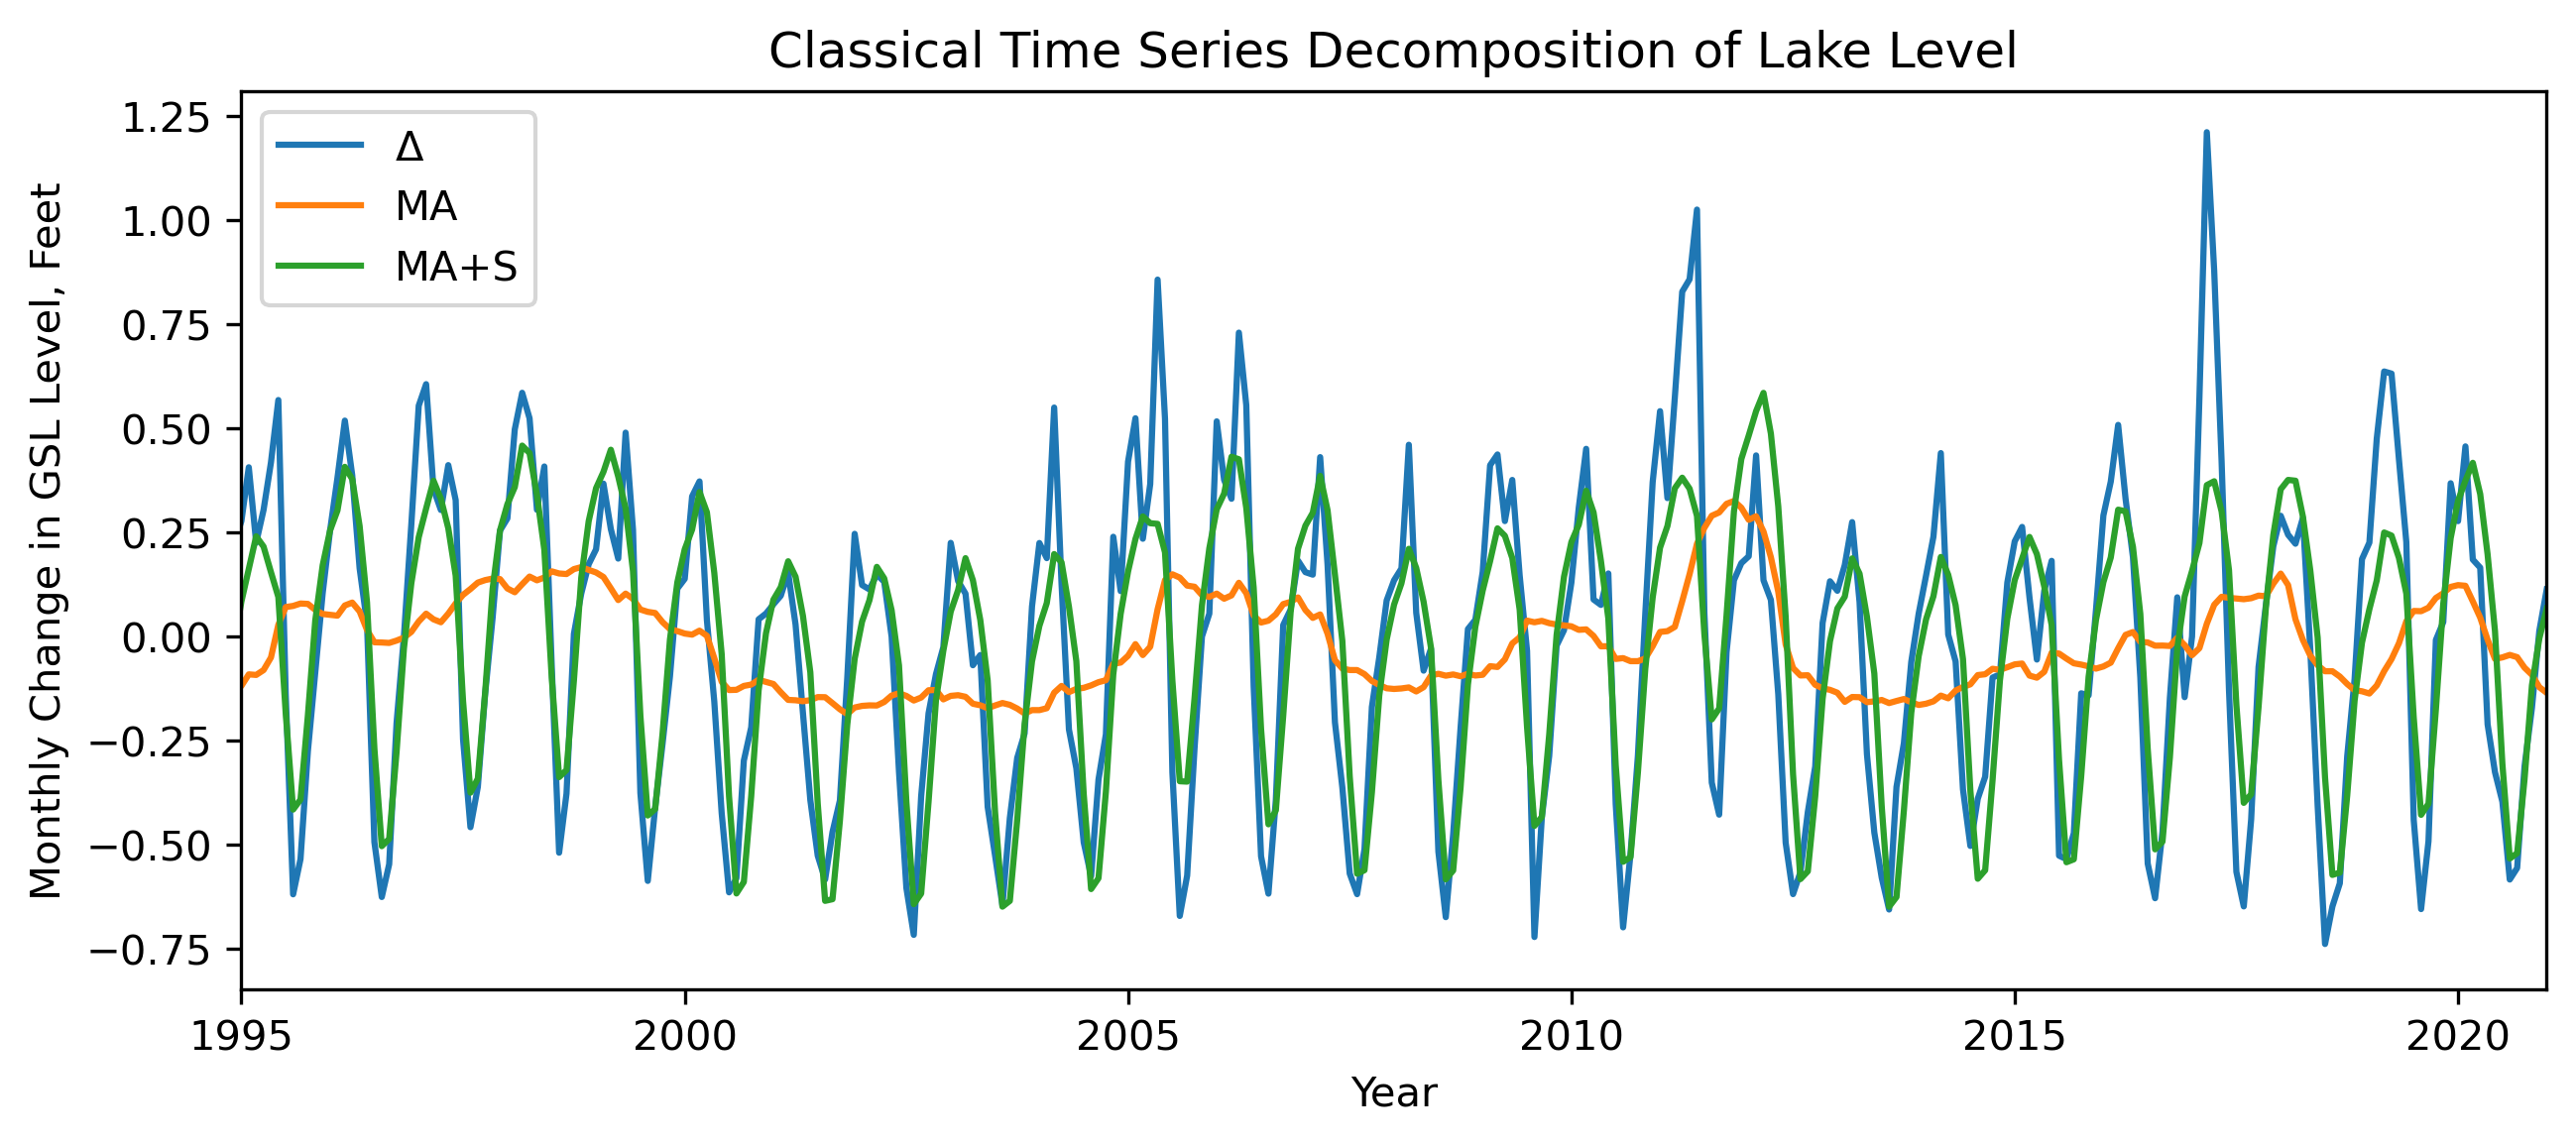

In [241]:
fig = plt.figure(figsize=(10,4), dpi=300)

plt.plot(year,  monthly['delta'], label=r'$\Delta$')
plt.plot(year, monthly.MA, label='MA')
plt.plot(year, monthly.S + monthly.MA, label='MA+S')
plt.xlim(1995, 2021)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Monthly Change in GSL Level, Feet')
plt.title('Classical Time Series Decomposition of Lake Level')

plt.savefig('Classical_decomp.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [240]:
seasonal1.values

array([ 0.20249905,  0.25263146,  0.33311847,  0.29681674,  0.20512012,
        0.06673173, -0.25553929, -0.48935484, -0.47104604, -0.26784581,
       -0.02515989,  0.11701608])

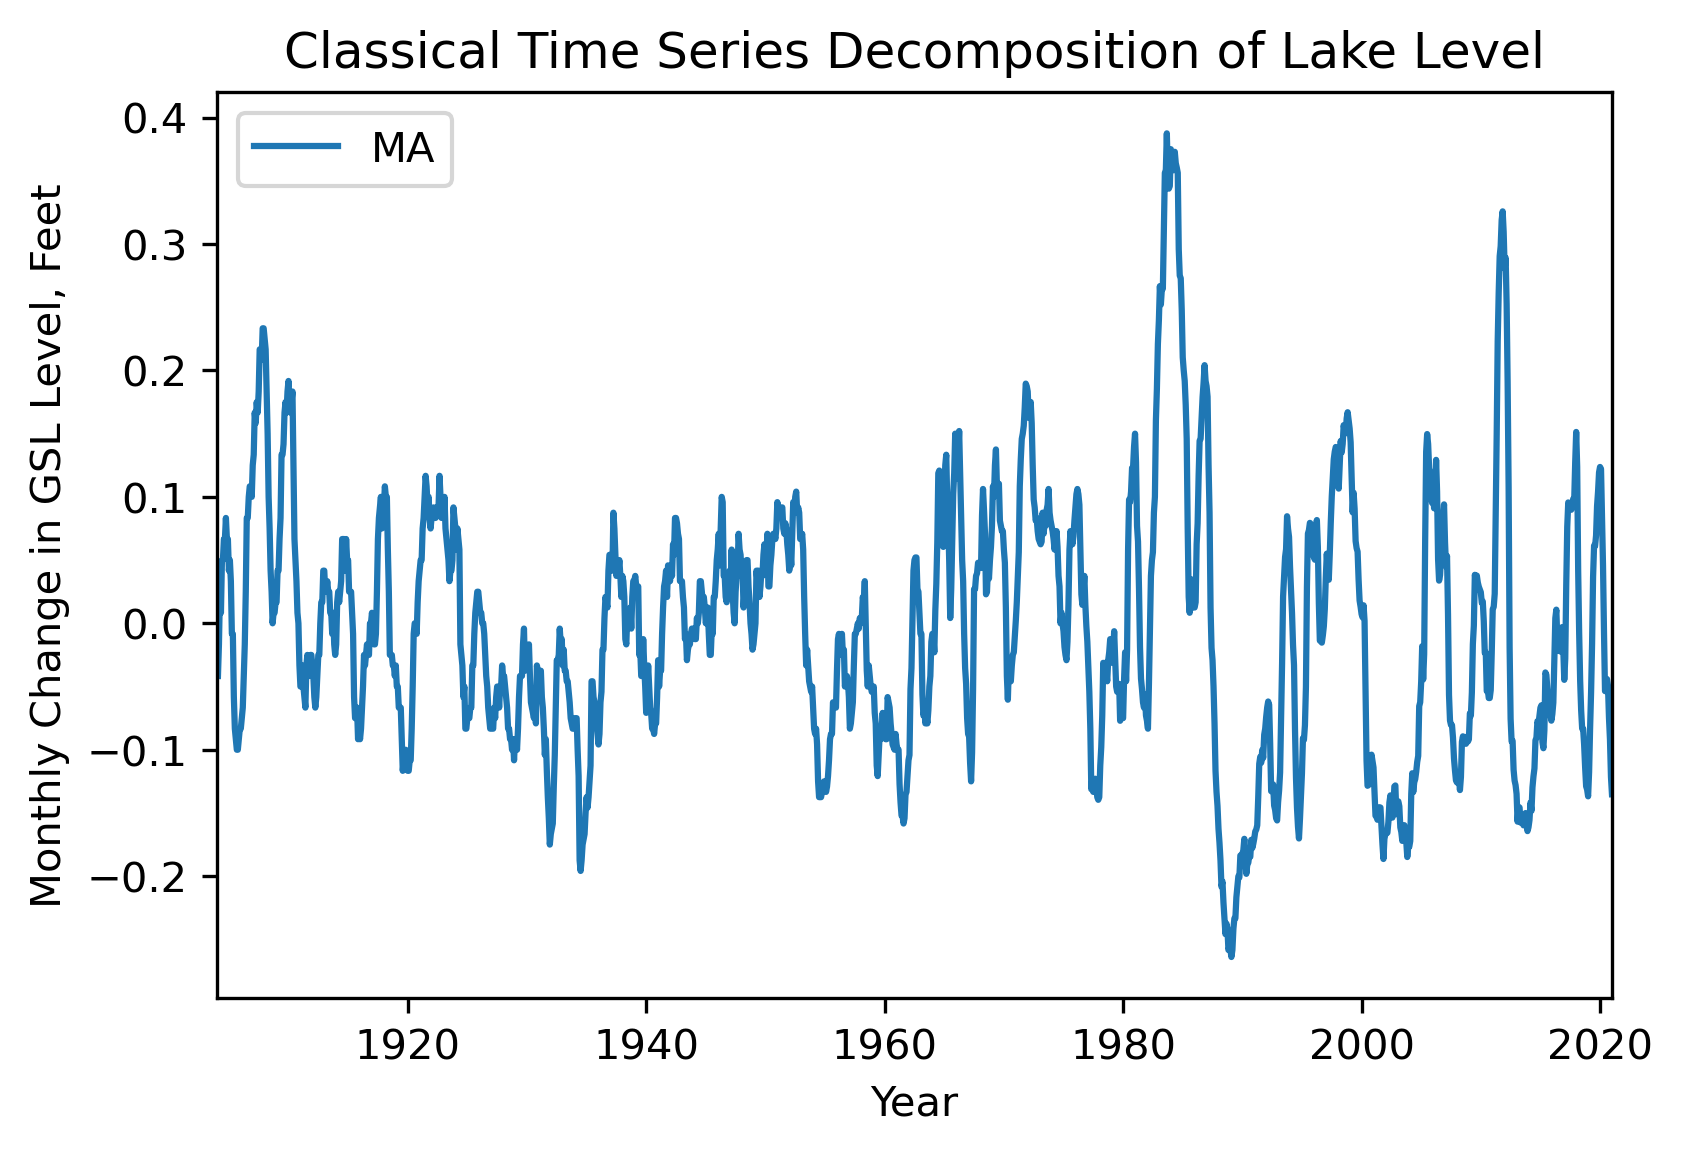

In [5]:
fig = plt.figure(figsize=(6,4), dpi=300)

#plt.plot(year,  monthly['delta'], label=r'$\Delta$')
plt.plot(year, monthly.MA, label='MA')
#plt.plot(year, monthly.S + monthly.MA, label='MA+S')
plt.xlim(1904, 2021)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Monthly Change in GSL Level, Feet')
plt.title('Classical Time Series Decomposition of Lake Level')

plt.savefig('Classical_decomp.pdf', dpi=300, bbox_inches='tight')
plt.show()

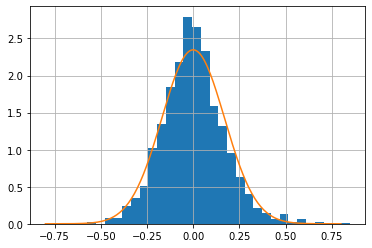

In [6]:
monthly.R.hist(bins=30, density=True)
d = st.norm(loc=0, scale=0.17)
domain = np.linspace(-0.8, 0.8, 200)
plt.plot(domain, d.pdf(domain))

# Processing All Weather Data

In [81]:
# Raw weather data
weather2 = pd.read_csv('GSL_monthly.csv')[133+336:-2]

# Find which columns have few nans
isna = []
for key in weather2.columns:
    v = np.count_nonzero(weather2[key].isna())/1404
    isna.append(v)
isna = np.array(isna)
cols = list(weather2.columns[np.nonzero(isna < 0.05)[0]])
cols.remove('Unnamed: 0')

# Remove these anomalous stations
#cols.remove('SNWD_USC00427744')
#cols.remove('PRCP_USC00427744')

# Make a list of columns to perform classical time series analysis on
cols2 = cols.copy()
cols2.remove('depth')
ma_cols = cols2 + ['delta']

In [50]:
# Read in the data
raw = pd.read_csv('GSL_monthly.csv')[132:-2]
raw.index = raw['Unnamed: 0']

# Select desired columns
monthly2 = raw[cols]

# Make a 'month' column
monthly2['month'] = np.array([int(monthly2.index[i][-2:]) for i in range(len(monthly2))])

# Take one finite difference of lake level
monthly2['delta'] = np.concatenate(([0], np.diff(monthly2.depth.values)))

# Take moving average 
for key in ma_cols:
    ma = np.convolve(monthly2[key].values, np.ones(12)/12, mode='valid')
    monthly2['MA_'+key] = np.concatenate((np.nan*np.zeros(11), ma))

# Cut off first elements
monthly2 = monthly2[336+1:]

# Find seasonal component
seasonal = pd.DataFrame(columns=ma_cols)
for key in ma_cols:
    seasonal[key] = monthly2.groupby('month')[key].mean()
    monthly2['S_'+key] = np.tile(np.roll(seasonal[key].values, shift=-1), 117-28)

# Find remainder
for key in ma_cols:
    monthly2['R_'+key] = monthly2[key] - monthly2['MA_' + key] - monthly2['S_' + key]

<ipython-input-50-dd67c3987bd2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly2['month'] = np.array([int(monthly2.index[i][-2:]) for i in range(len(monthly2))])
<ipython-input-50-dd67c3987bd2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly2['delta'] = np.concatenate(([0], np.diff(monthly2.depth.values)))
<ipython-input-50-dd67c3987bd2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [57]:
# Year array
year2 = (np.arange(len(monthly2)) + 1)/12 + 1932

In [51]:
seasonal

,PRCP_US1UTWS0009,PRCP_USC00421750,PRCP_USC00424846,SNOW_USC00424846,TMIN_USC00424846,TMAX_USC00424846,PRCP_USC00425183,SNOW_USC00425183,SNWD_USC00425183,TMIN_USC00425183,...,TMIN_USC00428741,TMAX_USC00428741,PRCP_USC00429560,SNOW_USC00429560,TMIN_USC00429560,TMAX_USC00429560,PRCP_USW00024175,TMIN_USW00024175,TMAX_USW00024175,delta
month,,,,,,,,,,,,,,,,,,,,,
1,14.912889,16.185933,8.656989,12.698237,-114.794018,-0.678411,13.444218,12.195741,119.176059,-86.464766,...,-65.400169,35.925674,4.207821,7.850549,-164.270247,-21.124816,2.995256,-72.410168,18.450419,0.225757
2,14.445075,19.062690,8.947478,10.142249,-112.990332,13.454551,14.191732,11.087703,109.778087,-65.123016,...,-42.943820,63.140405,5.088118,8.936381,-148.101592,-0.406501,2.576736,-41.240720,57.830126,0.273684
3,13.702346,22.980644,8.492378,6.920732,-70.763496,57.236433,16.563686,8.311176,36.947346,-20.644949,...,-5.629552,110.651975,5.511909,7.129511,-89.972500,54.172161,3.030963,1.731553,115.312480,0.346909
4,17.043389,26.153744,10.905098,5.700153,-22.295967,121.501435,18.507460,3.770567,4.430147,23.401555,...,34.146816,160.723970,8.287890,5.778675,-42.581816,121.287124,4.428925,46.474676,166.436953,0.286265
5,15.524221,22.020903,11.890344,0.845674,18.780479,179.226486,17.500750,0.448612,0.371543,67.588322,...,81.189211,214.476299,10.185469,2.012228,-1.688653,177.266852,5.844564,100.360472,223.490763,0.201113
6,8.133163,13.277929,9.107899,0.061569,52.988585,232.731279,11.791729,0.000000,0.000000,108.317915,...,129.354695,271.985187,9.482479,0.048837,37.041703,226.582934,4.061698,149.555127,280.427639,0.042782
7,5.042758,7.604641,4.840744,0.000000,89.767597,282.490665,4.741661,0.000000,0.000000,152.708207,...,176.206319,322.876562,6.303741,0.000000,66.058659,277.694514,2.663359,196.672003,334.786273,-0.302788
8,7.826101,10.842369,7.019770,0.000000,81.397377,273.073143,6.683881,0.000000,0.000000,145.520194,...,165.555640,310.798647,7.532756,0.000000,52.427645,269.528643,2.767053,182.425593,319.733937,-0.523646
9,9.354618,12.726616,8.548387,0.194253,38.602700,221.623055,10.877203,0.019540,0.281992,94.929438,...,112.613328,255.269288,9.416897,0.587059,4.252660,221.611895,3.337062,122.195117,257.175968,-0.473173


(1932.0, 2021.0)

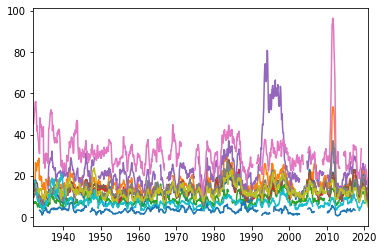

In [61]:
for key in ma_cols:
    if key[:4] == 'PRCP':
        plt.plot(year2, monthly2['MA_'+key])
        
plt.xlim(1932, 2021)

In [18]:
for key in ma_cols:
    if key[:4] == 'PRCP':
        print(key, monthly2['MA_'+key].mean())

PRCP_US1UTWS0009 13.974216818210117
PRCP_USC00421750 18.33283917335033
PRCP_USC00423671 13.9650473892529
PRCP_USC00424846 10.995491387996099
PRCP_USC00425183 15.073535856251585
PRCP_USC00425705 18.587695495691513
PRCP_USC00425847 17.596319151886476
PRCP_USC00427255 13.536488490892554
PRCP_USC00427744 43.189260903641646
PRCP_USC00428114 15.891612478609789
PRCP_USC00428741 15.334323688080877
PRCP_USC00429560 8.11840934447159
PRCP_USW00024175 4.208592688753016


# Aggregating Weather Data

In [83]:
# Read in the data
raw = pd.read_csv('GSL_monthly.csv')[132:-2]
raw.index = raw['Unnamed: 0']

# Select desired columns
monthly3 = raw[cols]

# Aggregate by type of stat
weather_stat_cols = {'PRCP':[], 'SNOW':[], 'TMIN':[], 'TMAX':[]}
for key in cols:
    if key[:4] in weather_stat_cols.keys():
        weather_stat_cols[key[:4]].append(key)
        
ma_cols = ['PRCP', 'SNOW', 'TMIN', 'TMAX', 'delta']

for col in ma_cols:
    if col != 'delta':
        monthly3[col] = monthly3[weather_stat_cols[col]].mean(axis=1)

# Make a 'month' column
monthly3['month'] = np.array([int(monthly3.index[i][-2:]) for i in range(len(monthly3))])

# Take one finite difference of lake level
monthly3['delta'] = np.concatenate(([0], np.diff(monthly3.depth.values)))

# Take moving average 
for key in ma_cols:
    ma = np.convolve(monthly3[key].values, np.ones(12)/12, mode='valid')
    monthly3['MA_'+key] = np.concatenate((np.nan*np.zeros(11), ma))

# Cut off first elements
monthly3 = monthly3[336+1:]

# Find seasonal component
seasonal3 = pd.DataFrame(columns=ma_cols)
for key in ma_cols:
    seasonal3[key] = monthly3.groupby('month')[key].mean()
    monthly3['S_'+key] = np.tile(np.roll(seasonal3[key].values, shift=-1), 117-28)

# Find remainder
for key in ma_cols:
    monthly3['R_'+key] = monthly3[key] - monthly3['MA_' + key] - monthly3['S_' + key]

monthly3.drop(columns=cols2, inplace=True)

<ipython-input-83-da4952db367a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly3[col] = monthly3[weather_stat_cols[col]].mean(axis=1)
<ipython-input-83-da4952db367a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly3['month'] = np.array([int(monthly3.index[i][-2:]) for i in range(len(monthly3))])
<ipython-input-83-da4952db367a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [84]:
monthly3

,depth,PRCP,SNOW,TMIN,TMAX,month,delta,MA_PRCP,MA_SNOW,MA_TMIN,...,S_PRCP,S_SNOW,S_TMIN,S_TMAX,S_delta,R_PRCP,R_SNOW,R_TMIN,R_TMAX,R_delta
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1932-02,4198.200000,18.194524,27.680556,-102.463183,18.030203,2,0.100000,16.209518,15.132940,2.122719,...,16.907241,18.862184,-76.046187,38.121143,0.273684,-14.922236,-6.314568,-28.539715,-173.671344,-0.011184
1932-03,4198.550000,18.370968,11.784946,-44.299215,65.019892,3,0.350000,16.468214,15.227922,2.738975,...,17.855562,16.938760,-32.248102,90.776397,0.346909,-15.952809,-20.381736,-14.790089,-177.879555,0.161425
1932-04,4198.850000,23.514486,17.200606,8.647318,146.598276,4,0.300000,17.088765,15.364718,3.264942,...,19.008869,11.372868,11.201411,148.191663,0.286265,-12.583148,-9.536980,-5.819036,-152.421261,0.142902
1932-05,4199.100000,12.474334,8.342857,51.218487,208.669051,5,0.250000,17.064948,15.861569,4.074362,...,16.888909,3.487148,56.321360,204.469748,0.201113,-21.479523,-11.005861,-9.177235,-146.785029,0.153054
1932-06,4199.400000,11.783333,6.333333,94.350000,251.016667,6,0.300000,17.757443,16.389347,3.225157,...,11.167644,0.447014,98.000999,259.708828,0.042782,-17.141754,-10.503028,-6.876156,-156.501573,0.323884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09,4192.660000,2.091494,0.494444,69.026667,258.720000,9,-0.556129,10.619434,7.301270,13.530650,...,10.890373,0.709593,78.333708,245.027311,-0.473173,-19.418312,-7.516418,-22.837692,-144.201807,-0.033512
2020-10,4192.348148,2.854839,0.946237,13.224731,185.676129,10,-0.311852,10.285038,6.890077,16.978948,...,14.671722,4.737139,21.577934,169.574777,-0.255483,-22.101921,-10.680980,-25.332151,-146.879058,0.018382
2020-11,4192.176667,10.566828,10.755556,-40.040000,92.200000,11,-0.171481,9.932658,6.474800,16.992032,...,15.376804,13.534905,-36.222348,80.471740,-0.017345,-14.742635,-9.254149,-20.809684,-151.495885,-0.062192


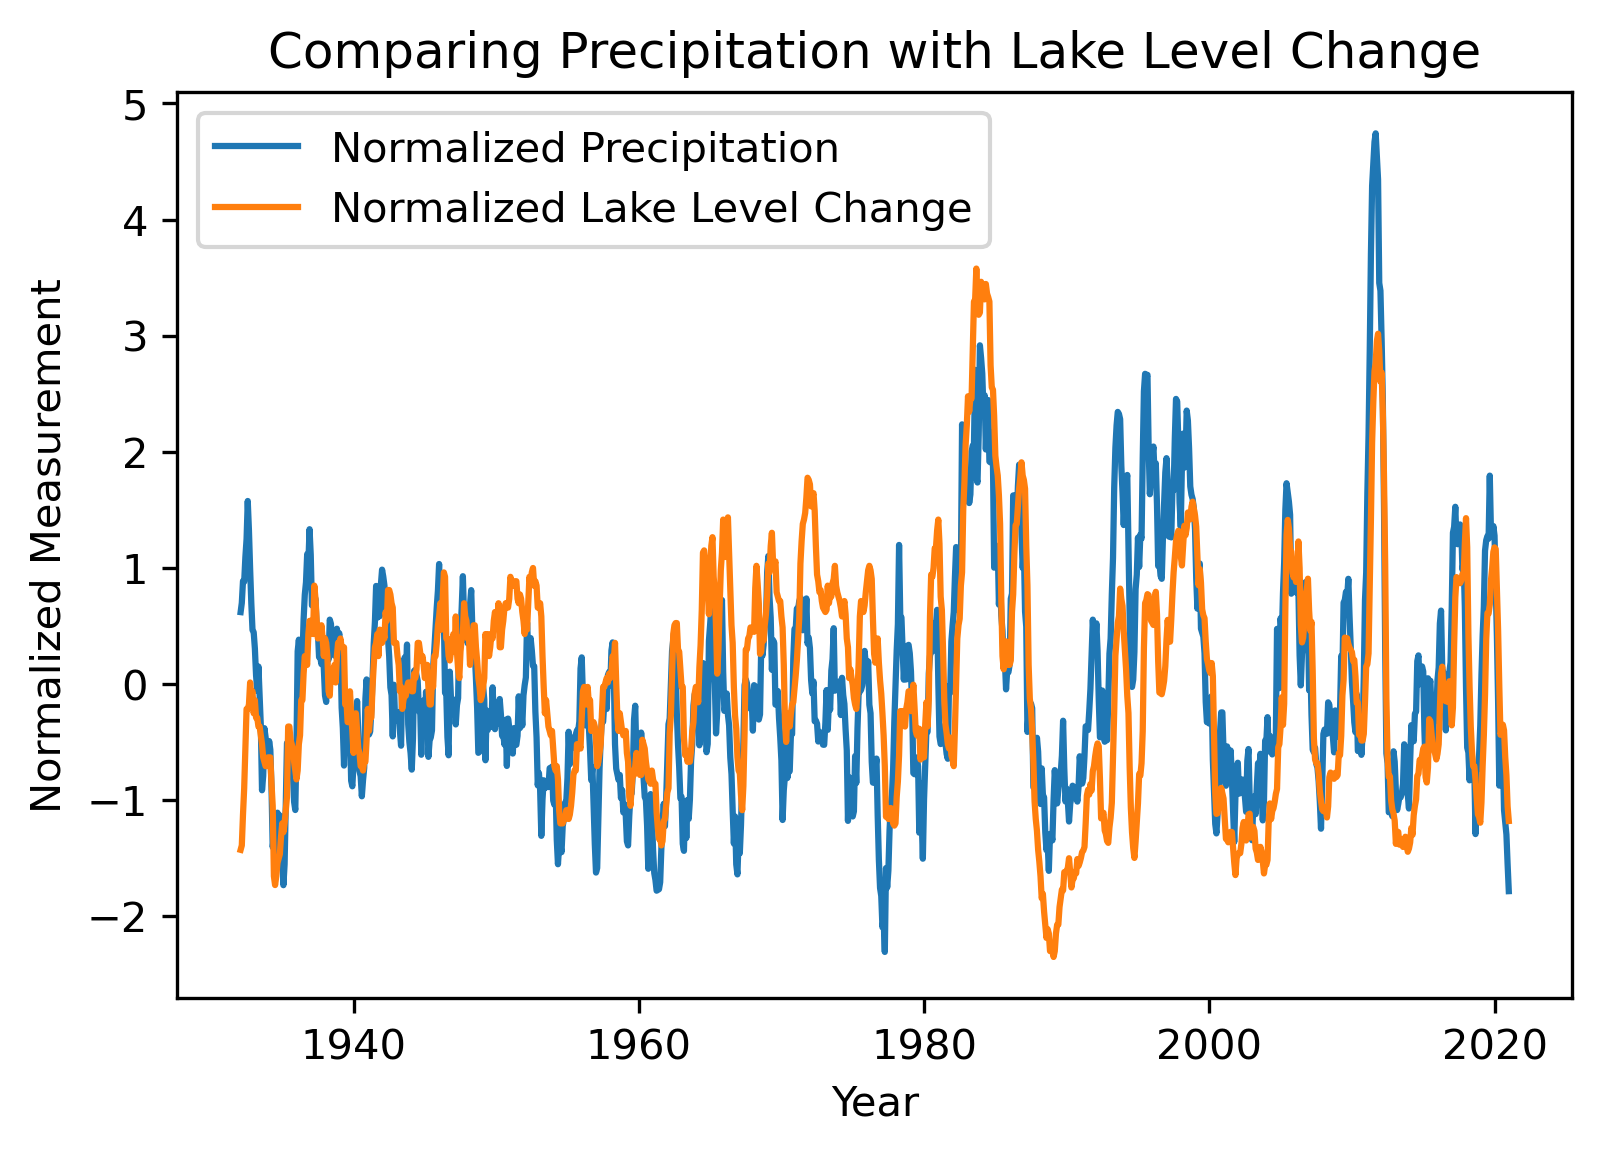

In [138]:
fig = plt.figure(figsize=(6,4), dpi=300)

plt.plot(year2, normalize(monthly3['MA_PRCP']), label='Normalized Precipitation')
plt.plot(year2, normalize(monthly3['MA_delta']), label='Normalized Lake Level Change')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Normalized Measurement')
plt.title('Comparing Precipitation with Lake Level Change')

plt.savefig('precip.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [102]:
monthly3

,depth,PRCP,SNOW,TMIN,TMAX,month,delta,MA_PRCP,MA_SNOW,MA_TMIN,...,S_PRCP,S_SNOW,S_TMIN,S_TMAX,S_delta,R_PRCP,R_SNOW,R_TMIN,R_TMAX,R_delta
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1932-02,4198.200000,18.194524,27.680556,-102.463183,18.030203,2,0.100000,16.209518,15.132940,2.122719,...,16.907241,18.862184,-76.046187,38.121143,0.273684,-14.922236,-6.314568,-28.539715,-173.671344,-0.011184
1932-03,4198.550000,18.370968,11.784946,-44.299215,65.019892,3,0.350000,16.468214,15.227922,2.738975,...,17.855562,16.938760,-32.248102,90.776397,0.346909,-15.952809,-20.381736,-14.790089,-177.879555,0.161425
1932-04,4198.850000,23.514486,17.200606,8.647318,146.598276,4,0.300000,17.088765,15.364718,3.264942,...,19.008869,11.372868,11.201411,148.191663,0.286265,-12.583148,-9.536980,-5.819036,-152.421261,0.142902
1932-05,4199.100000,12.474334,8.342857,51.218487,208.669051,5,0.250000,17.064948,15.861569,4.074362,...,16.888909,3.487148,56.321360,204.469748,0.201113,-21.479523,-11.005861,-9.177235,-146.785029,0.153054
1932-06,4199.400000,11.783333,6.333333,94.350000,251.016667,6,0.300000,17.757443,16.389347,3.225157,...,11.167644,0.447014,98.000999,259.708828,0.042782,-17.141754,-10.503028,-6.876156,-156.501573,0.323884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09,4192.660000,2.091494,0.494444,69.026667,258.720000,9,-0.556129,10.619434,7.301270,13.530650,...,10.890373,0.709593,78.333708,245.027311,-0.473173,-19.418312,-7.516418,-22.837692,-144.201807,-0.033512
2020-10,4192.348148,2.854839,0.946237,13.224731,185.676129,10,-0.311852,10.285038,6.890077,16.978948,...,14.671722,4.737139,21.577934,169.574777,-0.255483,-22.101921,-10.680980,-25.332151,-146.879058,0.018382
2020-11,4192.176667,10.566828,10.755556,-40.040000,92.200000,11,-0.171481,9.932658,6.474800,16.992032,...,15.376804,13.534905,-36.222348,80.471740,-0.017345,-14.742635,-9.254149,-20.809684,-151.495885,-0.062192


In [ ]:
def VAR_forecast(k, n):
    
    """
    Uses a VAR model to make a forecast of length k.
    
    Parameters:
        k (int): forecast length
        n (int): forecast start point (must be <= 359-k)
    
    Returns:
        forecast (k, ndarray)
        error (float): average L^2 error
    """

    # Select desired data (throw away first column, take difference, then throw away first row)
    X = data.iloc[:, 1:].diff()[1:]

    # Create VAR model
    model = VAR(X[:n])

    # Fit the model 
    #results = model.fit(maxlags=6, ic='aic')
    results = model.fit(12)

    # Forecast 
    lag_order = results.k_ar
    forecast1 = results.forecast(X.values[-lag_order:], k)

    # Plot results
    plt.figure(figsize=(6,4), dpi=300)
    plt.plot(np.arange(n+k-36, n+k), X.iloc[n+k-36:n+k, -1], label='True')
    plt.plot(np.arange(n, n+k), forecast1[:, -1], label='Forecast')

    # Label
    plt.ylabel('Monthly Change in Lake Level')
    plt.xlabel('Months since December 1958')
    plt.title('Using a VAR model to Predict Changes in Lake Level')
    plt.legend(loc='lower left')
    plt.show()
    
    
    # Calcalute mean squared error
    mse = np.sum((X.iloc[n:n+k, -1]-forecast1[:, -1])**2)/k
    
    return forecast1[:, -1], mse

In [141]:
def normalize(series, k=0):
    mu = series[:len(series)-k].mean()
    s = series[:len(series)-k].std()
    
    return (series-mu)/s, s, mu

In [224]:
k = 12
N = 1000 # 1068
train_length = 50*12

def VARMAX_forecast(k=12, N=1000, train_length=50*12, savetitle=None):

    # Construct X
    X = np.zeros((train_length+k, 2))
    X[:, 0], s0, mu0 = normalize(monthly3['MA_PRCP'][N-train_length:N+k], k)
    X[:, 1], s1, mu1 = normalize(monthly3['MA_delta'][N-train_length:N+k], k)

    # Create and fit model
    model = VARMAX(X[:-k])
    results = model.fit(maxlags=6, ic='aic')

    # Forecast 
    forecast1 = results.forecast(steps=k)

    # Plot results
    #plt.figure(figsize=(6,4), dpi=300)
    #plt.plot(np.arange(N+k-36, N+k), X.iloc[N+k-36:N+k, -1], label='True')
    #plt.plot(np.arange(N, N+k), forecast1[:, -1], label='Forecast')

    month = int((year2[N] - int(year2[N]))*12 + 0.5)
    seas = np.roll(seasonal3.delta.values, shift=-month-1)
    seas = np.tile(seas, k//12)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), dpi=300)
    
    forecast_change = seas+forecast1[:, 1]*s1 + mu1
    ax1.plot(year[N:N+k], monthly3.delta[N:N+k], label='actual')
    ax1.plot(year[N:N+k], forecast_change, label='forecast')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Monthly Lake Level Change, Feet')
    ax1.legend()
    
    forecast_depth = monthly3.depth[N] + np.concatenate(([0], forecast_change[:-1].cumsum()))
    ax2.plot(year[N:N+k], monthly3.depth[N:N+k], label='actual')
    ax2.plot(year[N:N+k], forecast_depth, label='forecast')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Lake Level, Feet')
    ax2.legend()
    
    plt.suptitle('Vector ARMA Forecasting of GSL Level')
    plt.tight_layout()
    
    if savetitle is not None: plt.savefig(savetitle, bbox_inches='tight', dpi=300)
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(monthly3.depth[N:N+k]-forecast_depth)))
    
    return rmse

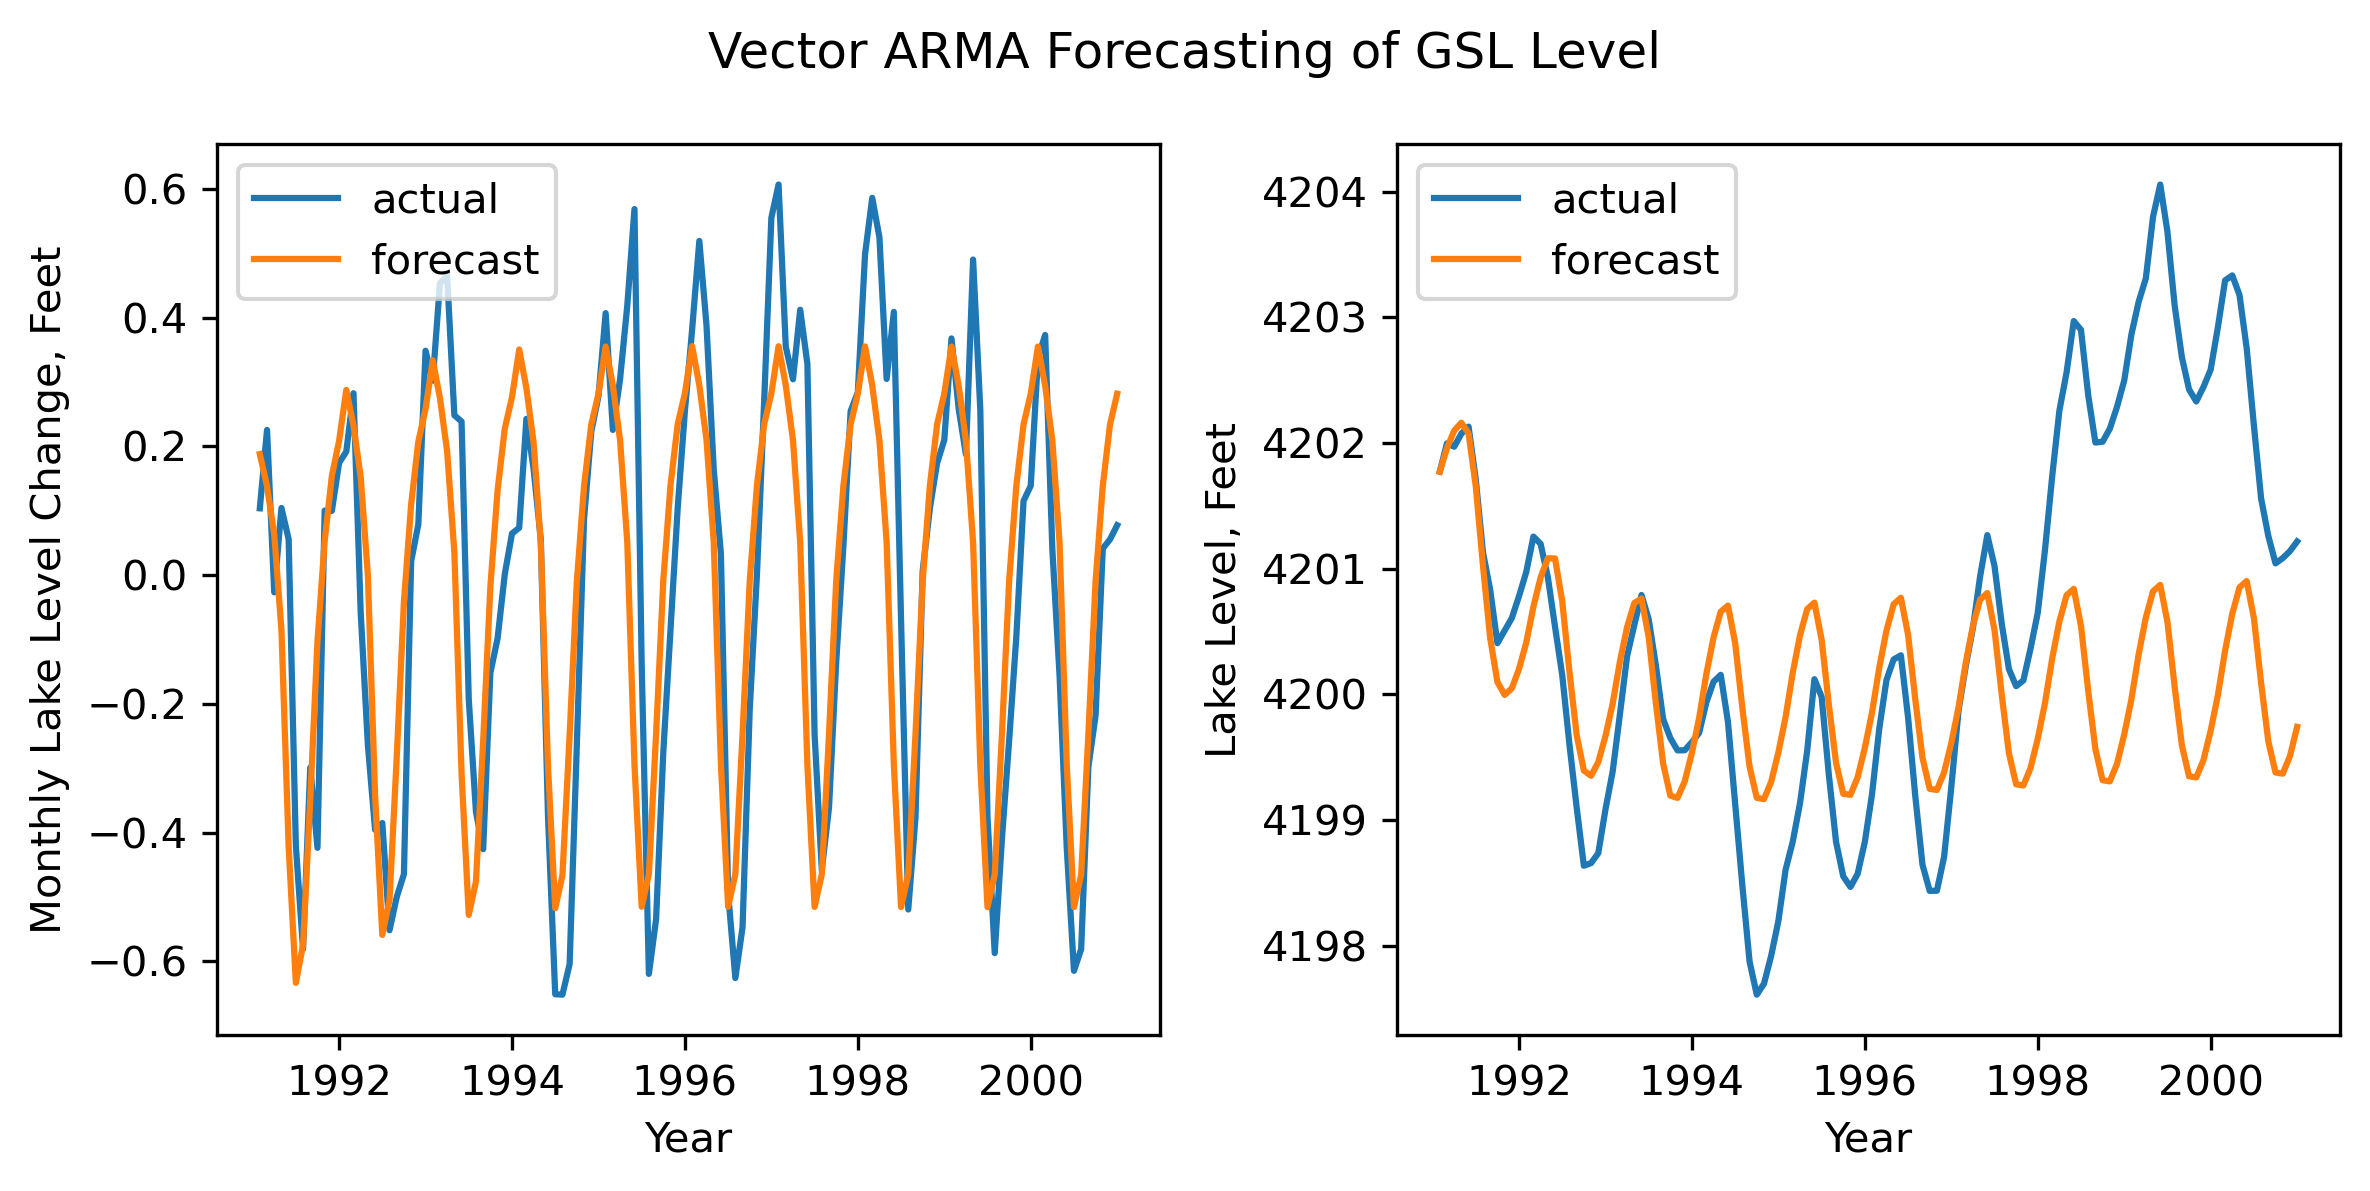

In [230]:
rmse = VARMAX_forecast(k=10*12, N=1068-10*12-10*12-10*12, train_length=50*12, savetitle=None)

In [218]:
year2[600]

1982.0833333333333

In [220]:
50*12

600

In [181]:
monthly3.depth[N] + np.concatenate(([0], monthly3.delta.values[N+1:N+k].cumsum()))

array([4194.26      , 4193.73354839, 4193.19870968, 4192.72633333,
       4192.59      , 4192.44866667, 4192.51322581, 4192.80419355,
       4193.17655172, 4193.68516129, 4194.01666667, 4194.20774194])

In [173]:
monthly3.delta.values[N+1]

-0.526451612902747

In [180]:
monthly3.depth[N:N+k]

Unnamed: 0
2015-06    4194.260000
2015-07    4193.733548
2015-08    4193.198710
2015-09    4192.726333
2015-10    4192.590000
2015-11    4192.448667
2015-12    4192.513226
2016-01    4192.804194
2016-02    4193.176552
2016-03    4193.685161
2016-04    4194.016667
2016-05    4194.207742
Name: depth, dtype: float64

In [168]:
monthly3.iloc[N]

depth       4194.260000
PRCP           6.533333
SNOW           0.000000
TMIN         130.272222
TMAX         297.716667
month          6.000000
delta          0.181935
MA_PRCP       14.107256
MA_SNOW        4.099579
MA_TMIN       39.161141
MA_TMAX      174.091851
MA_delta      -0.038861
S_PRCP        11.167644
S_SNOW         0.447014
S_TMIN        98.000999
S_TMAX       259.708828
S_delta        0.042782
R_PRCP       -18.741567
R_SNOW        -4.546593
R_TMIN        -6.889918
R_TMAX      -136.084012
R_delta        0.178014
Name: 2015-06, dtype: float64

In [157]:
seasonal3.delta

month
1     0.225757
2     0.273684
3     0.346909
4     0.286265
5     0.201113
6     0.042782
7    -0.302788
8    -0.523646
9    -0.473173
10   -0.255483
11   -0.017345
12    0.130796
Name: delta, dtype: float64

In [160]:
np.roll(seasonal3.delta.values, shift=-5+1)

array([ 0.20111296,  0.04278217, -0.3027876 , -0.52364625, -0.47317289,
       -0.25548269, -0.01734503,  0.13079642,  0.22575718,  0.27368405,
        0.34690855,  0.28626471])

In [150]:
len(monthly3)

1068

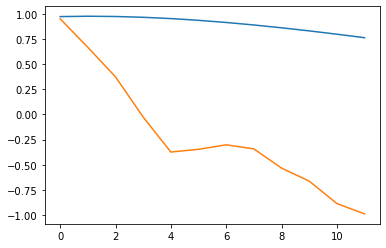

In [132]:
plt.plot(forecast1[:, 1])
plt.plot(X[-12:, 1])

In [130]:
X[-12:, 1]

array([ 0.95031437,  0.66627781,  0.37329386, -0.0269914 , -0.37450441,
       -0.34727366, -0.3026774 , -0.34308432, -0.53391729, -0.66356929,
       -0.88648305, -0.98964811])

In [115]:
len(year2)

1068

/Users/jwmurri/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


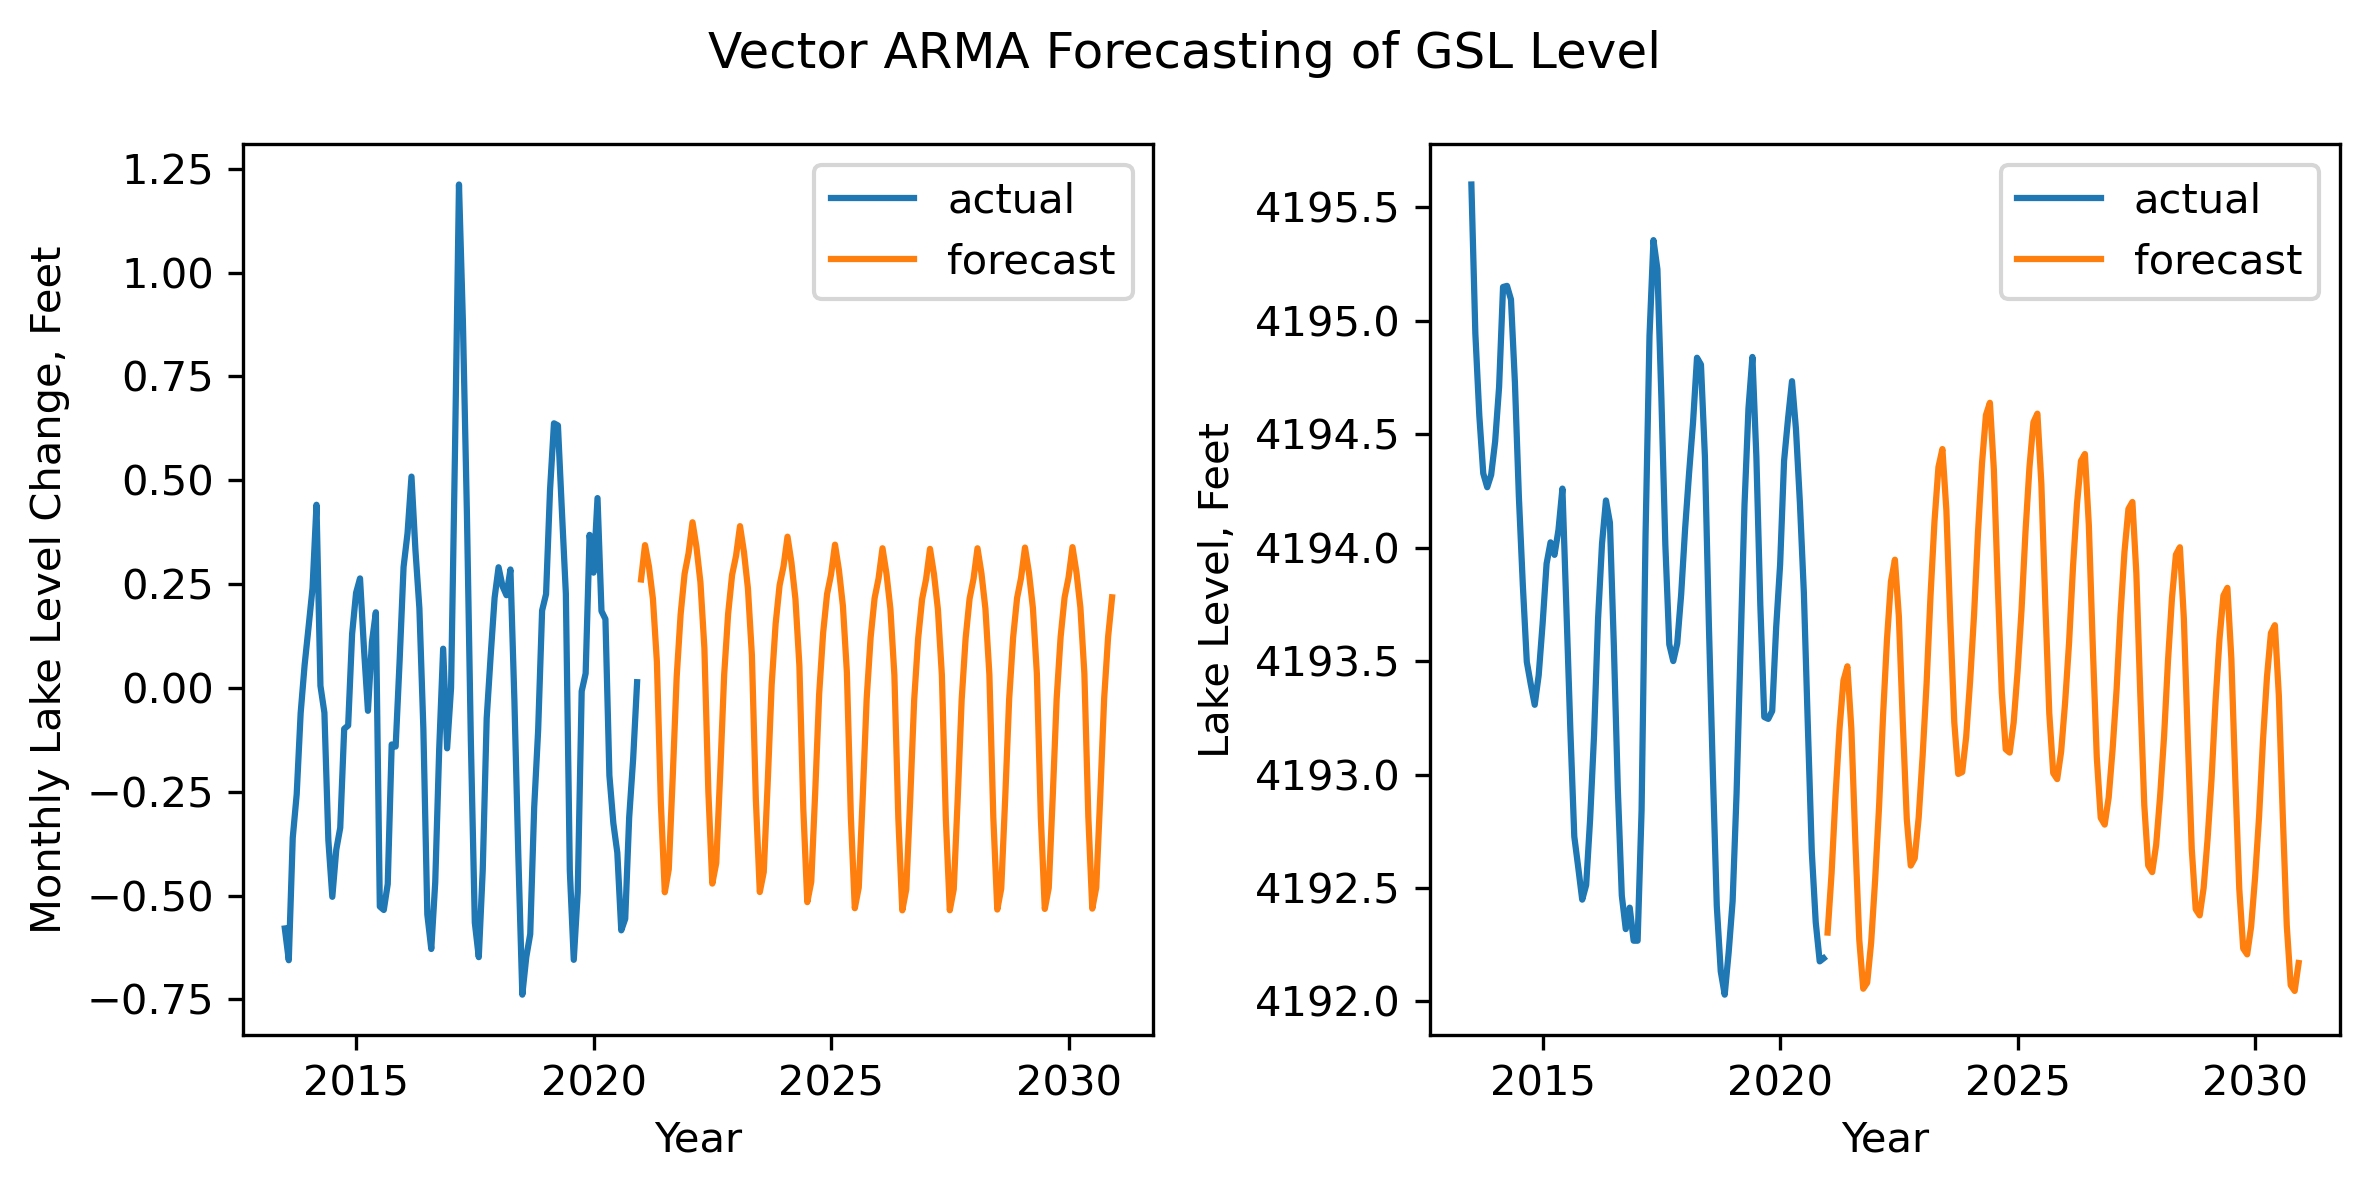

In [255]:
k=12*10
N=1067
train_length=N

# Construct X
X = np.zeros((train_length, 2))
X[:, 0], s0, mu0 = normalize(monthly3['MA_PRCP'][N-train_length:N], k=0)
X[:, 1], s1, mu1 = normalize(monthly3['MA_delta'][N-train_length:N], k=0)

# Create and fit model
model = VARMAX(X[:-k])
results = model.fit(maxlags=6, ic='aic')

# Forecast 
forecast1 = results.forecast(steps=k)


month = int((year2[N] - int(year2[N]))*12 + 0.5)
seas = np.roll(seasonal3.delta.values, shift=-month-1)
seas = np.tile(seas, k//12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), dpi=300)
    
forecast_change = seas+forecast1[:, 1]*s1 + mu1
ax1.plot(year2[N-90:N], monthly3.delta[N-90:N], label='actual')
ax1.plot(year2[N:N+k], forecast_change, label='forecast')
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Lake Level Change, Feet')
ax1.legend()
    
forecast_depth = monthly3.depth[N] + np.concatenate(([0], forecast_change[:-1].cumsum()))
ax2.plot(year2[N-90:N], monthly3.depth[N-90:N], label='actual')
ax2.plot(year2[N:N+k], forecast_depth, label='forecast')
ax2.set_xlabel('Year')
ax2.set_ylabel('Lake Level, Feet')
ax2.legend()
    
plt.suptitle('Vector ARMA Forecasting of GSL Level')
plt.tight_layout()
    
plt.savefig('future_prediction.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [250]:
year2 = (np.arange(2000) + 1)/12 + 1932

In [253]:
year2[N:N+k]

array([2021.        , 2021.08333333, 2021.16666667, 2021.25      ,
       2021.33333333, 2021.41666667, 2021.5       , 2021.58333333,
       2021.66666667, 2021.75      , 2021.83333333, 2021.91666667,
       2022.        , 2022.08333333, 2022.16666667, 2022.25      ,
       2022.33333333, 2022.41666667, 2022.5       , 2022.58333333,
       2022.66666667, 2022.75      , 2022.83333333, 2022.91666667,
       2023.        , 2023.08333333, 2023.16666667, 2023.25      ,
       2023.33333333, 2023.41666667, 2023.5       , 2023.58333333,
       2023.66666667, 2023.75      , 2023.83333333, 2023.91666667,
       2024.        , 2024.08333333, 2024.16666667, 2024.25      ,
       2024.33333333, 2024.41666667, 2024.5       , 2024.58333333,
       2024.66666667, 2024.75      , 2024.83333333, 2024.91666667,
       2025.        , 2025.08333333, 2025.16666667, 2025.25      ,
       2025.33333333, 2025.41666667, 2025.5       , 2025.58333333,
       2025.66666667, 2025.75      , 2025.83333333, 2025.91666

In [254]:
k

120